In [8]:
import pandas as pd
import math
from collections import Counter

def levenshtein_distance(s1: str, s2: str) -> int:
    """Compute Levenshtein edit distance between s1 and s2 (DP)."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1, start=1):
        current_row = [i]
        for j, c2 in enumerate(s2, start=1):
            insertions = previous_row[j] + 1
            deletions = current_row[j - 1] + 1
            substitutions = previous_row[j - 1] + (0 if c1 == c2 else 1)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def ngrams(seq, n):
    return [tuple(seq[i:i + n]) for i in range(len(seq) - n + 1)] if len(seq) >= n else []

def count_clip_matches(reference, hypothesis, n):
    ref_ngrams = Counter(ngrams(reference, n))
    hyp_ngrams = Counter(ngrams(hypothesis, n))
    return sum(min(hyp_ngrams[ng], ref_ngrams.get(ng, 0)) for ng in hyp_ngrams)

def sentence_bleu(reference, hypothesis, max_n=4, smoothing=True):
    """Compute BLEU for a single pair (char-based)."""
    precisions = []
    for n in range(1, max_n + 1):
        matched = count_clip_matches(reference, hypothesis, n)
        total = max(1, len(hypothesis) - n + 1)
        if smoothing:
            p_n = (matched + 1) / (total + 1)
        else:
            p_n = matched / total
        precisions.append(p_n)
    if min(precisions) == 0:
        geo_mean = 0.0
    else:
        log_prec_sum = sum((1 / max_n) * math.log(p) for p in precisions)
        geo_mean = math.exp(log_prec_sum)
    ref_len = len(reference)
    hyp_len = len(hypothesis)
    if hyp_len == 0:
        bp = 0.0
    elif hyp_len > ref_len:
        bp = 1.0
    else:
        bp = math.exp(1 - ref_len / hyp_len)
    return bp * geo_mean * 100.0

In [9]:
import pandas as pd
import math
from collections import Counter

def levenshtein_distance(s1: str, s2: str) -> int:
    """Compute Levenshtein edit distance between s1 and s2 (DP)."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1, start=1):
        current_row = [i]
        for j, c2 in enumerate(s2, start=1):
            insertions = previous_row[j] + 1
            deletions = current_row[j - 1] + 1
            substitutions = previous_row[j - 1] + (0 if c1 == c2 else 1)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def ngrams(seq, n):
    return [tuple(seq[i:i + n]) for i in range(len(seq) - n + 1)] if len(seq) >= n else []

def count_clip_matches(reference, hypothesis, n):
    ref_ngrams = Counter(ngrams(reference, n))
    hyp_ngrams = Counter(ngrams(hypothesis, n))
    return sum(min(hyp_ngrams[ng], ref_ngrams.get(ng, 0)) for ng in hyp_ngrams)

def sentence_bleu(reference, hypothesis, max_n=4, smoothing=True):
    """Compute BLEU for a single pair (char-based)."""
    precisions = []
    for n in range(1, max_n + 1):
        matched = count_clip_matches(reference, hypothesis, n)
        total = max(1, len(hypothesis) - n + 1)
        if smoothing:
            p_n = (matched + 1) / (total + 1)
        else:
            p_n = matched / total
        precisions.append(p_n)
    if min(precisions) == 0:
        geo_mean = 0.0
    else:
        log_prec_sum = sum((1 / max_n) * math.log(p) for p in precisions)
        geo_mean = math.exp(log_prec_sum)
    ref_len = len(reference)
    hyp_len = len(hypothesis)
    if hyp_len == 0:
        bp = 0.0
    elif hyp_len > ref_len:
        bp = 1.0
    else:
        bp = math.exp(1 - ref_len / hyp_len)
    return bp * geo_mean * 100.0

def calculate_accuracies(csv_path):
    df = pd.read_csv(csv_path)

    expected_cols = {'eng', 'actual', 'predicted'}
    if not expected_cols.issubset(df.columns):
        raise ValueError(f"CSV must have columns {expected_cols}")

    total_words = len(df)
    correct_words = 0
    total_chars_for_acc = 0
    correct_chars = 0
    total_edit_distance = 0
    total_ref_chars = 0

    references = []
    hypotheses = []
    row_metrics = []  # store per-row metrics

    for _, row in df.iterrows():
        english = str(row['eng']).strip()
        actual = str(row['actual']).strip()
        predicted = str(row['predicted']).strip()

        references.append(actual)
        hypotheses.append(predicted)

        # --- Word-level accuracy ---
        word_correct = 1 if actual == predicted else 0
        if word_correct:
            correct_words += 1

        # --- Character accuracy ---
        max_len = max(len(actual), len(predicted))
        total_chars_for_acc += max_len
        char_matches = sum(a == b for a, b in zip(actual, predicted))
        correct_chars += char_matches
        char_acc = (char_matches / max_len * 100) if max_len > 0 else 0

        # --- CER ---
        ed = levenshtein_distance(actual, predicted)
        total_edit_distance += ed
        total_ref_chars += len(actual)
        cer = (ed / len(actual) * 100) if len(actual) > 0 else 0

        # --- Sentence BLEU ---
        bleu = sentence_bleu(actual, predicted, max_n=4, smoothing=True)

        row_metrics.append({
            'english': english,
            'actual': actual,
            'predicted': predicted,
            'word_match': word_correct * 100,
            'char_acc': char_acc,
            'cer': cer,
            'bleu': bleu
        })

    # --- Corpus-level metrics ---
    word_acc = correct_words / total_words * 100 if total_words > 0 else 0
    char_acc = correct_chars / total_chars_for_acc * 100 if total_chars_for_acc > 0 else 0
    cer = total_edit_distance / total_ref_chars * 100 if total_ref_chars > 0 else 0
    corpus_bleu = sum(m['bleu'] for m in row_metrics) / len(row_metrics)

    print(f"✅ Word-level accuracy:      {word_acc:.2f}%")
    print(f"✅ Character-level accuracy: {char_acc:.2f}%")
    print(f"✅ Character Error Rate (CER): {cer:.2f}%")
    print(f"✅ Avg Sentence BLEU-4 (chars, smoothed): {corpus_bleu:.2f}%")

    metrics_df = pd.DataFrame(row_metrics)

    def show_top_and_bottom(metric):
        print(f"\n🔹 Top 10 by {metric}:")
        print(metrics_df.sort_values(metric, ascending=False)[['english', 'actual', 'predicted', metric]].head(10).to_string(index=False))
        print(f"\n🔸 Bottom 10 by {metric}:")
        print(metrics_df.sort_values(metric, ascending=True)[['english','actual', 'predicted', metric]].head(10).to_string(index=False))

    for metric in ['word_match', 'char_acc', 'cer', 'bleu']:
        show_top_and_bottom(metric)

    return metrics_df, word_acc, char_acc, cer, corpus_bleu

✅ Word-level accuracy:      39.51%
✅ Character-level accuracy: 71.53%
✅ Character Error Rate (CER): 17.08%
✅ Avg Sentence BLEU-4 (chars, smoothed): 71.31%

🔹 Top 10 by word_match:
   english    actual predicted  word_match
    beemon     बीमों     बीमों         100
   rajasva     राजसव     राजसव         100
    huerta    हुएरता    हुएरता         100
       soy       सोय       सोय         100
   shaakir     शाकिर     शाकिर         100
springdale सपरिंगडेल सपरिंगडेल         100
     burch       बरच       बरच         100
    choron     चोरों     चोरों         100
    siyasi    सियासी    सियासी         100
  amaanati    अमानती    अमानती         100

🔸 Bottom 10 by word_match:
     english      actual   predicted  word_match
maitrologist मैटरोलॉजिसट मैटरोलाजिसट           0
       taras         तरस       तारास           0
  composites   कंपोज़िटस    कंपोजीटस           0
     ganguly     गांगुली      गेंगली           0
      gehlot       गहलोत      गेहलोट           0
         man         मैन 

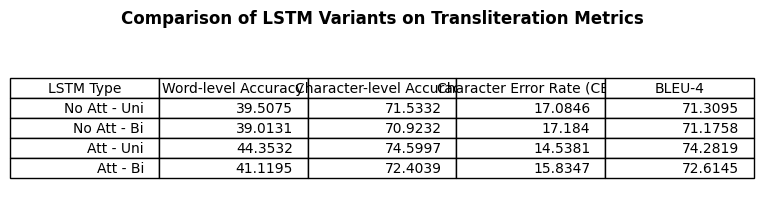

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- compute all metrics ---
metrics_df1, word_acc1, char_acc1, cer1, bleu1 = calculate_accuracies('uni_no_attn.csv')
metrics_df2, word_acc2, char_acc2, cer2, bleu2 = calculate_accuracies('bi_no_attn.csv')
metrics_df3, word_acc3, char_acc3, cer3, bleu3 = calculate_accuracies('uni_attn.csv')
metrics_df4, word_acc4, char_acc4, cer4, bleu4 = calculate_accuracies('bi_attn.csv')

# --- create summary dataframe ---
summary_df = pd.DataFrame({
    "LSTM Type": ["No Att - Uni", "No Att - Bi", "Att - Uni", "Att - Bi"],
    "Word-level Accuracy": [word_acc1, word_acc2, word_acc3, word_acc4],
    "Character-level Accuracy": [char_acc1, char_acc2, char_acc3, char_acc4],
    "Character Error Rate (CER)": [cer1, cer2, cer3, cer4],
    "BLEU-4": [bleu1, bleu2, bleu3, bleu4]
})

# --- round values and display ---
summary_df = summary_df.round(4)
print(summary_df)

# --- pretty table visualization ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
tbl = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)
plt.title("Comparison of LSTM Variants on Transliteration Metrics", pad=20, fontsize=12, fontweight='bold')
plt.show()

In [18]:
metrics_df1 = calculate_accuracies('predictions/uni_no_attn_lstm_predictions.csv')

✅ Word-level accuracy:      17.19%
✅ Character-level accuracy: 52.23%
✅ Character Error Rate (CER): 26.78%
✅ Avg Sentence BLEU-4 (chars, smoothed): 56.97%

🔹 Top 10 by word_match:
     english     actual  predicted  word_match
  baharampur   बहरामपुर   बहरामपुर         100
    varshiya     वर्षिय     वर्षिय         100
  vaahikayen   वाहिकाएं   वाहिकाएं         100
paathyaatmak पाठ्यात्मक पाठ्यात्मक         100
     gopalak     गोपालक     गोपालक         100
 vishnupuraa विष्णुपुरा विष्णुपुरा         100
    bandhuon     बंधुओं     बंधुओं         100
niveshkartaa निवेशकर्ता निवेशकर्ता         100
  updraviyon उपद्रवियों उपद्रवियों         100
      antrit    आंत्रित    आंत्रित         100

🔸 Bottom 10 by word_match:
     english        actual     predicted  word_match
maitrologist मैट्रोलॉजिस्ट मैट्रोलाजिस्ट           0
       ibiza         इबीजा        इिबज़ा           0
       pulse          पल्स          पलसे           0
     yudhrat       युद्धरत        युधररत           0
      baha

In [ ]:
metrics_df2 = calculate_accuracies('predictions/uni_attn_lstm_predictions.csv')